In [119]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score

from tqdm import tqdm

In [2]:
ds_p = xr.open_mfdataset("../era5/era5-nordics-precipitation_ymon.nc")

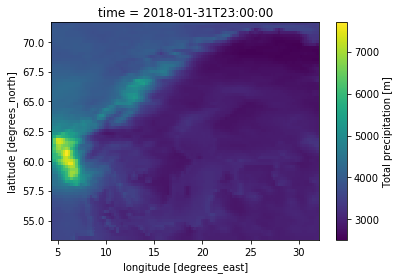

In [141]:
ds_p.tp[0].plot()

In [11]:
ds_p.tp[0]

<xarray.DataArray 'tp' (latitude: 73, longitude: 111)>
dask.array<shape=(73, 111), dtype=float32, chunksize=(73, 111)>
Coordinates:
    time       datetime64[ns] 2018-01-31T23:00:00
  * longitude  (longitude) float32 4.5 4.75 5.0 5.25 5.5 5.75 6.0 6.25 6.5 ...
  * latitude   (latitude) float32 71.5 71.25 71.0 70.75 70.5 70.25 70.0 ...
Attributes:
    long_name:  Total precipitation
    units:      m

In [5]:
df = pd.read_csv("swe_plots.csv")

In [7]:
df.dropna(inplace=True)

In [8]:
df.size

290766

In [9]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,volspruce,volotherdec,pine_spruce_ratio,voltotal
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,275.743796,0.000000,0.000000,353.878134
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,3.928420,0.000000,0.000000,3.928420
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,216.131302,33.220735,0.000000,249.352037
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,20.430038,0.000000,0.918713,267.383396
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,5.976354,0.000000,0.000000,36.277369


In [92]:
df["voltotal"] = df["volbirch"] + \
    df["volcontorta"] + \
    df["volpine"] + \
    df["volspruce"] + \
    df["volotherdec"]

In [93]:
df["volbirchpct"] = df["volbirch"]/df["voltotal"]
df["volcontortapct"] = df["volcontorta"]/df["voltotal"]
df["volpinepct"] = df["volpine"]/df["voltotal"]
df["volsprucepct"] = df["volspruce"]/df["voltotal"]
df["volotherdec"] = df["volotherdec"]/df["voltotal"]

In [116]:
df["class"] = df.apply(lambda r: 1 if r["volpinepct"] > 0.5 else 2 if r["volsprucepct"] > 0.5 else 3, axis = 1)

In [46]:
ds_p.tp[0].sel(longitude=18.491601, latitude=64.134697, method='nearest').values.flat[0]

2895.375

In [47]:
df["p1"] = df.apply(lambda row: ds_p.tp[0].sel(longitude = row["longitude"], latitude = row["latitude"], method='nearest').values.flat[0], axis = 1)

In [94]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,...,p06,p07,p08,p09,p10,p11,volbirchpct,volcontortapct,volpinepct,volsprucepct
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,...,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934,0.220794,0.0,0.00000,0.779206
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,...,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934,0.000000,0.0,0.00000,1.000000
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,...,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749,0.000000,0.0,0.00000,0.866772
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,...,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749,0.060033,0.0,0.86356,0.076407
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,...,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749,0.835259,0.0,0.00000,0.164741


In [51]:
for m in tqdm(range(0, 12)):
    df["p%02d" % m] = df.apply(lambda row: ds_p.tp[m].sel(longitude = row["longitude"], latitude = row["latitude"], method='nearest').values.flat[0], axis = 1)

100%|██████████| 12/12 [16:57<00:00, 83.97s/it]


In [140]:
len(df)

20769

In [52]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,...,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,...,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,...,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,...,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,...,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,...,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749


In [53]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,...,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,...,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,...,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,...,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,...,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,...,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749


In [55]:
df.columns

Index(['year', 'plotid', 'landuseclass', 'easting', 'northing', 'longitude',
       'latitude', 'volbirch', 'volcontorta', 'volpine', 'volspruce',
       'volotherdec', 'pine_spruce_ratio', 'voltotal', 'p1', 'p00', 'p01',
       'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11'],
      dtype='object')

In [95]:
df2 = df[["volpinepct", "p00", "p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11"]]

In [96]:
df2

,volpinepct,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,0.000000,2895.375000,688.053650,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
1,0.000000,2895.375000,688.053650,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
4,0.000000,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
5,0.863560,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
6,0.000000,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
7,0.076235,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
8,0.000000,2895.375000,688.053650,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
12,1.000000,2883.105469,670.904236,640.888306,797.471252,1138.534790,1350.093994,1877.850342,1776.878662,1182.670410,1092.921875,991.268005,962.445374
15,1.000000,2883.105469,670.904236,640.888306,797.471252,1138.534790,1350.093994,1877.850342,1776.878662,1182.670410,1092.921875,991.268005,962.445374
16,0.908827,2883.105469,670.904236,640.888306,797.471252,1138.534790,1350.093994,1877.850342,1776.878662,1182.670410,1092.921875,991.268005,962.445374


In [107]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df2[df2.columns[1:]], df2["volpinepct"])

In [109]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
y_pred = rf.predict(X_test)

In [111]:
mean_squared_error(y_test, y_pred)

0.13878536879061212

In [112]:
r2_score(y_test, y_pred)

0.17707976240346102

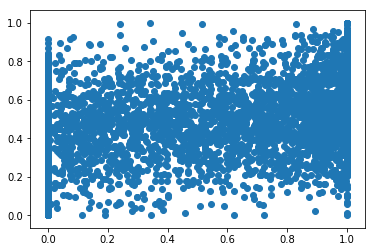

In [113]:
plt.scatter(y_test, y_pred)

In [117]:
df3 = df[["class", "p00", "p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11"]]

In [118]:
df3.head()

,class,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,2,2895.375000,688.053650,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
1,2,2895.375000,688.053650,652.348999,810.703918,1112.989502,1411.823486,2046.308228,1765.825684,1170.814575,1087.813599,991.687439,986.369934
4,2,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
5,1,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749
6,3,2990.176025,739.350647,653.804504,790.853271,1074.139771,1305.675049,1978.625000,1787.002075,1189.902710,1147.987793,1074.559082,1055.817749


In [132]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df3[df3.columns[1:]], df3["class"])

In [134]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
y_pred = clf.predict(X_test)

In [136]:
accuracy_score(y_pred, y_test)

0.5503562487964567

In [137]:
confusion_matrix(y_pred, y_test)

array([[1815,  762,  515],
       [ 549,  999,  365],
       [  80,   64,   44]])